In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


import pickle
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

train_data = pd.read_json('train.json')
test_data = pd.read_json('test.json')

# 1) Plotting From Data
## Which Cuisines are Most Represented?

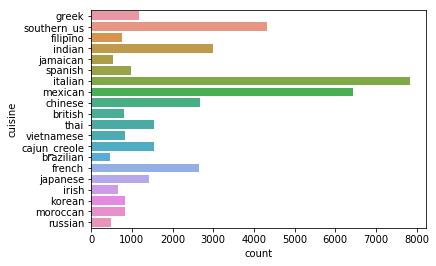

In [4]:
#sns.countplot(y = 'cuisine', data=train_data[train_data.cuisine.isin(train_data.cuisine.value_counts().head(10).index)])
sns.countplot(y = 'cuisine', data=train_data)

## Which Cuisines use the Most Ingredients?

/Users/EdKay/py3env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 30)

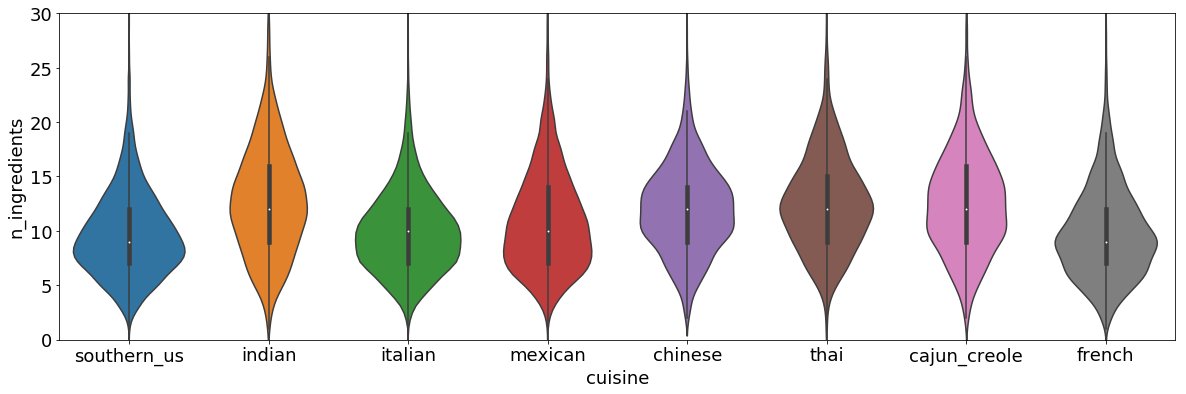

In [5]:
train_data['n_ingredients'] = train_data.ingredients.map(lambda x:len(x))
matplotlib.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(figsize=(20,6))
sns.violinplot(ax = axes,x='cuisine',y='n_ingredients',data=train_data[train_data.cuisine.isin(train_data.cuisine.value_counts().head(8).index)])
axes.set_ylim(0,30)

## One Hot Encoding of List Data to allow further plots and learning
(This step takes a minute or two)

In [7]:
train_ingredients = pd.get_dummies(train_data.ingredients.apply(pd.Series).stack()).sum(level=0)
test_ingredients = pd.get_dummies(test_data.ingredients.apply(pd.Series).stack()).sum(level=0)
#Could also do an inner join to get union of the two
train_ingredients, test_ingredients = train_ingredients.align(test_ingredients,
                                                                    join='left', 
                                                                    axis=1)


test_ingredients = test_ingredients.fillna(0)
train_data_encoded = pd.concat([train_data['cuisine'],train_ingredients],axis = 1)
test_data_encoded = pd.concat([test_data['id'],test_ingredients],axis = 1)

## Plot Most Common Ingredients

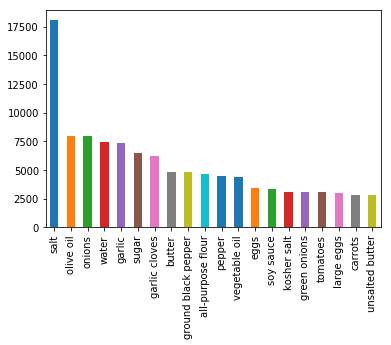

In [8]:
matplotlib.rcParams.update({'font.size': 10})
tempIngredientsPlot = train_data_encoded.drop(['cuisine'],axis=1).sum().sort_values(ascending=False).head(20).plot.bar()

## Plot most Common Ingredients stratified by cuisine

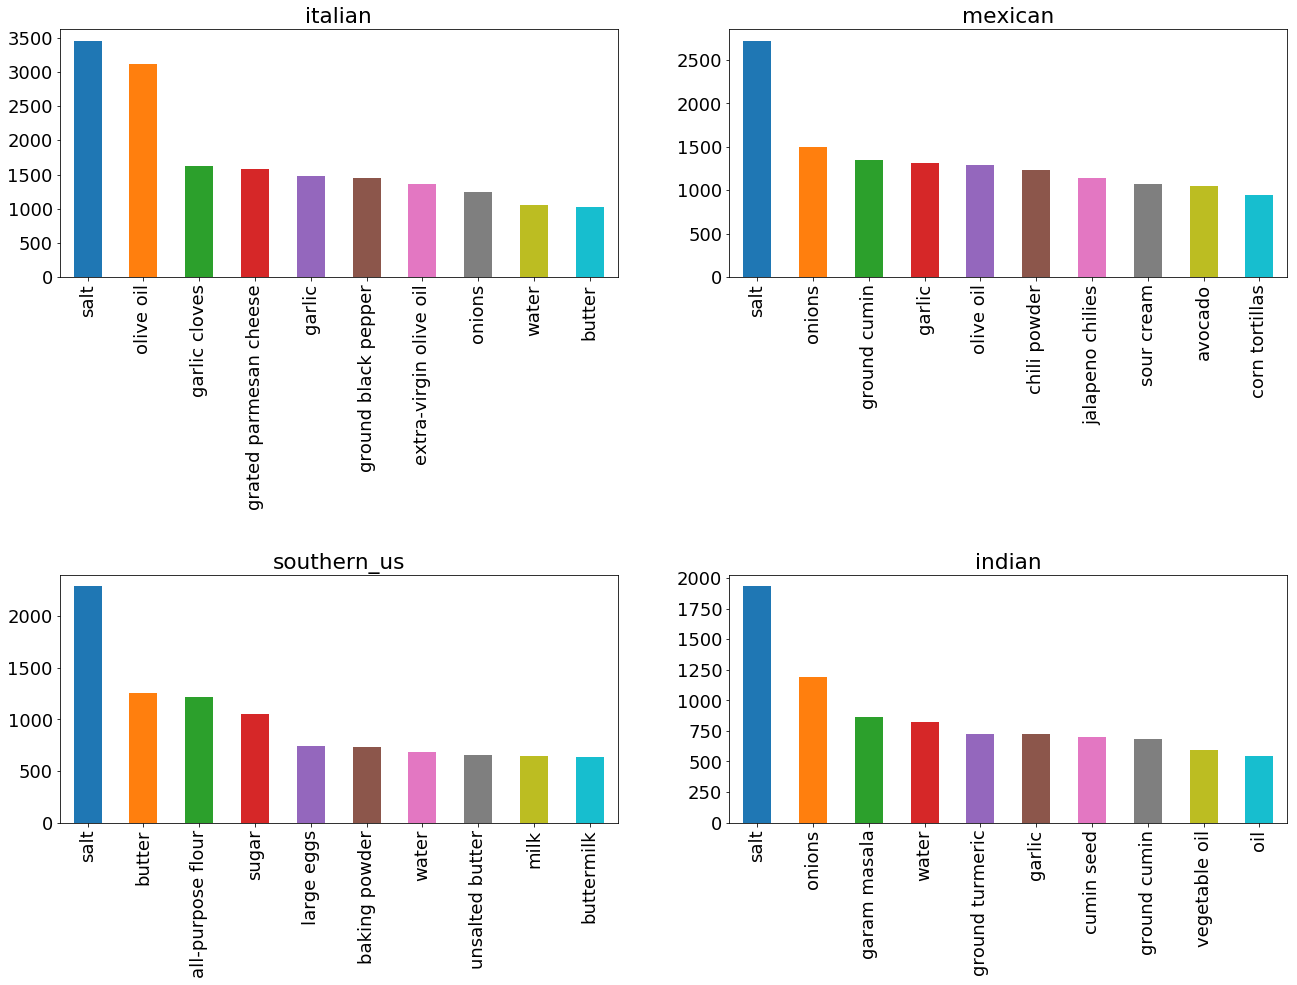

In [15]:
matplotlib.rcParams.update({'font.size': 18})
nRows = 2
nCols = 2
fig, axes = plt.subplots(nRows, nCols)
fig.subplots_adjust(wspace = 0.2,hspace= 1.2,bottom=0.3)
for i in range(nRows):
    for j in range(nCols):
        axes[i,j].set_title(train_data_encoded.cuisine.value_counts().head(nRows*nCols).index[j+(i*nCols)])
        train_data_encoded[train_data_encoded.cuisine == train_data_encoded.cuisine.value_counts().head(nRows*nCols).index[j+(i*nCols)]]\
                                                        .drop(['cuisine'],axis=1)\
                                                        .sum()\
                                                        .sort_values(ascending=False)\
                                                        .head(10)\
                                                        .plot\
                                                        .bar(ax = axes[i,j],figsize=(22,19))
                                

matplotlib.rcParams.update({'font.size': 10})

# 2) Fit Various Models
## Logistic Regression

In [17]:
logistic_regression_pipeline = make_pipeline(LogisticRegression())
#Search for Best Parameters with Grid Search
param_grid = [
  {'logisticregression__C': [0.1, 0.5, 1, 5, 10]},
 ]
grid = GridSearchCV(logistic_regression_pipeline,param_grid=param_grid,cv=3)
grid.fit(train_data_encoded.drop('cuisine',axis =1), train_data_encoded.cuisine)
index_best_logistic_regression_c = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
best_logistic_regression_c = param_grid[0]['logisticregression__C'][index_best_logistic_regression_c]
print("Logistic Regression:")
print("CV Results from Best Parameters",grid.cv_results_['mean_test_score'][index_best_logistic_regression_c])
print("Best Value of C:", best_logistic_regression_c)

##Fit Model on all training data with best parameter
#logistic_regression_pipeline_tuned = make_pipeline(LogisticRegression(C=best_logistic_regression_c))
#logistic_regression_pipeline_tuned.fit(train_data_encoded.drop('cuisine',axis =1), train_data_encoded.cuisine)

##Predict on Training Data
#test_data['cuisine'] = logistic_regression_pipeline_tuned.predict(test_ingredients)
#test_data[['id','cuisine']].to_csv("lr_submission.csv",index = False)

Logistic Regression:
CV Results from Best Parameters 0.775783174938402
Best Value of C: 1


## Random Forest
NB the data is so high dimensional that having anything other than linear decision boundaries will add unecessary complciations and probably give worse accuracy. We will try and random forest as it doesn't require much parameter tuning so we can check its accuracy fairly quickly.

In [22]:
random_forest_pipeline = make_pipeline(RandomForestClassifier())
#Search for Best Parameters with Grid Search
param_grid = [
  {'randomforestclassifier__n_estimators': [5, 8, 10, 20, 40]},
 ]
grid = GridSearchCV(random_forest_pipeline,param_grid=param_grid,cv=3)
grid.fit(train_data_encoded.drop('cuisine',axis =1), train_data_encoded.cuisine)
index_best_random_forest_n_estimators = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
best_random_forest_n_estimators = param_grid[0]['randomforestclassifier__n_estimators'][index_best_random_forest_n_estimators]
print("Random Forest:")
print("CV Results from Best Parameters",grid.cv_results_['mean_test_score'][index_best_random_forest_n_estimators])
print("Best Value of C:", best_random_forest_n_estimators)

##Fit Model on all training data with best parameter
#random_forest_pipeline_tuned = make_pipeline(RandomForestClassifier(n_estimators=best_random_forest_n_estimators))
#random_forest_pipeline_tuned.fit(train_data_encoded.drop('cuisine',axis =1), train_data_encoded.cuisine)

##Predict on Training Data
#test_data.drop('cuisine',axis =1)
#test_data['cuisine'] = random_forest_pipeline_tuned.predict(test_ingredients)
#test_data[['id','cuisine']].to_csv("rf_submission.csv",index = False)

Random Forest:
CV Results from Best Parameters 0.7029969326695832
Best Value of C: 40


## Linear SVM
This takes an extremely long time given the high dimensionality of the input data

In [23]:
linear_svm_pipeline  = make_pipeline(SVC(kernel='linear'))
#Search for Best Parameters with Grid Search
param_grid = [
  {'svc__C': [0.5, 1, 5]},
 ]
grid = GridSearchCV(linear_svm_pipeline,param_grid=param_grid,cv=3)
grid.fit(train_data_encoded.drop('cuisine',axis =1), train_data_encoded.cuisine)
index_best_linear_svm_c = np.where(grid.cv_results_['rank_test_score']==1)[0][0]
best_linear_svm_c = param_grid[0]['svc__C'][index_best_linear_svm_c]
print("Linear SVM:")
print("CV Results from Best Parameters",grid.cv_results_['mean_test_score'][index_best_linear_svm_c])
print("Best Value of C:", best_linear_svm_c)

##Fit Model on all training data with best parameter
#linear_svm_pipeline_tuned = make_pipeline(SVC(kernel='linear',C=best_linear_svm_c))
#linear_svm_pipeline_tuned.fit(train_data_encoded.drop('cuisine',axis =1), train_data_encoded.cuisine)

##Predict on Training Data
#test_data.drop('cuisine',axis =1)
#test_data['cuisine'] = linear_svm_pipeline_tuned.predict(test_ingredients)
#test_data[['id','cuisine']].to_csv("svm_submission.csv",index = False)

Linear SVM:
CV Results from Best Parameters 0.7571026298587017
Best Value of C: 0.5


# Potential Extensions

## Different Encoding of Text
Reduce Natural Variation in words by Lemmatizing (e.g. changes eggs to egg, and walk/walked/walks/walking to walk) and then using a Term Frequency - Inverse Document Frequency transform. This is common in text recognition and tells you how often a term comes up in a document weighted by the frequency of that term in other documents